<a href="https://colab.research.google.com/github/emmanuellfc/EM_Tufts_Fall2023/blob/main/GeneralFiniteDifferences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Package dependencies.
!apt install libcgal-dev libeigen3-dev
!pip install -U pygalmesh
!pip install networkx

In [211]:
# Imports.
import pygalmesh
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
#import matplotlib.colormaps as cmaps
from typing import Iterable
from typing import Callable
from typing import Optional
import math

In [212]:
# Rperesents an individual node of the graph data structure representation of the mesh.
class MeshPoint: pass
class MeshPoint:
  def __init__(self,pos: tuple = (0,0)):
    self.pos = tuple(pos) # (x,y) position of the node.
    self.pot: Optional[float] = None # Solution of potential for this node point.
    self.is_boundary = False # Is this node associated with a boundary condition?
  def __getitem__(self,index):
    return self.pos[index]
  def __eq__(self,other: MeshPoint):
    return self.pos is other.pos
  def __hash__(self):
    return hash(self.pos)

  # The "gamma" function is one half the sum of inverse square distances between these points. i.e. 0.5(1/(x1-x2)^2 + 1/(y1-y2)^2).
  def gamma(self,other: MeshPoint) -> float:
    if  len(self.pos) is not len(other.pos):
      raise Exception('Incompatable dimensionality computing gamma: ' + self.pos + ' and ' + other.pos)
    tmp: float = 0
    for dim in range(len(self.pos)):
      # Don't divide by 0.
      if math.isclose(self.pos[dim],other.pos[dim]): continue
      tmp += pow(self.pos[dim]-other.pos[dim],-2)
    return tmp#/2 # Small optimization - the /2 actually divides off later in the math.

# Represents a mesh (contains a graph) for the system we're trying to solve.
class FiniteDifferences:
  def __init__(self):
    self.max_edge_size: float = None # What maximum edge size should we pass to the mesher?
    self.num_neighbors: int = None # How many neighbors should we try to make per non-boundary node?
    self.boundary_conditions: Callable[[MeshPoint],Optional[float]] = None # A function that takes a node and if boundary node: return pot; else: return None.
    self.edge_points: list = None # List of (x,y) points that form the boundary of the 2D space.
    self.mesh = None # Pygalmesh mesh.points list.
    self.mesh_points: list = None # List of non-boundary condition MeshPoints that form the region of 2D space.
    self.dirichlet_points: list = None # List of MeshPoints that are boundary condition points (only Dirichlet points).
    self.all_points: list = None # Simply self.mesh_points + self.dirichlet_points after they're constructed.
    self.graph = nx.Graph() # Graph data structure representing the region. Nodes of the graph are MeshPoint objects.
    self.systems_matrix = None # m x m matrix where m is the number of non-boundary points in the space. (m is how many points we need to solve for.)
    self.systems_rhs = None # m x 1 vector that serves as the right hand side of the system of linear equations.
    self.solution = None # Solution result of the systems matrix (m x 1 vector).

  def set_max_edge_size(self,max: float):
    self.max_edge_size = max
  def set_num_neighbors(self,num: int):
    self.num_neighbors = num

  # Inform the method of boundary conditions that exist for the problem.
  # We expect a function that takes a MeshPoint object and returns a boundary potential for it if it should have one. Expects None for "not a boundary point."
  def inform_with_boundary_conditions(self,conditions: Callable[[MeshPoint],Optional[float]]):
    self.boundary_conditions = conditions

  # Manually inject a list of (x,y) points instead of calling the mesher.
  def inform_with_manual_mesh(self,manual_mesh: Iterable[tuple]):
    if self.boundary_conditions is None:
      raise Exception('Error: Need to inform with boundary conditions before providing a manual mesh.')
    # First store a copy of the mesh points.
    self.mesh = list(manual_mesh)
    self.__assemble_boundary_points()

  # Make a list of points from some edge conditions. This makes a surface "mesh" from a boundary definition. The boundary is a list of points.
  def make_points_from_boundary(self,boundary: Iterable[tuple]):
    print('Generating a mesh from the boundary provided...')
    if self.max_edge_size is None:
      raise Exception('Error: Need to inform with a max edge size before providing boundary points.')
    if self.boundary_conditions is None:
      raise Exception('Error: Need to inform with boundary conditions before providing boundary points.')
    # First, store the edge points that we were passed.
    self.edge_points = list(boundary)
    # The constraints we pass to pygalmesh need to look like [(0,1),(1,2),...(n-2,n-1),(n-1,0)]. The last constraint closes the boundary.
    constraints = [ (i-1,i) for i in range(1,len(self.edge_points)) ] + [(len(self.edge_points)-1,0)]
    # Ask pygalmesh to make a mesh for us.
    self.mesh = pygalmesh.generate_2d(
      self.edge_points,
      constraints,
      max_edge_size=self.max_edge_size,
      num_lloyd_steps=10,
    ).points
    self.__assemble_boundary_points()

  # Not intended to be called from outside the class (weird I know). Helper function to assemble internal data structures.
  def __assemble_boundary_points(self):
    # Store the points as MeshPoint objects.
    self.mesh_points = []
    self.dirichlet_points = []
    for pt in self.mesh:
      mesh_point = MeshPoint(pt)
      boundary_result = self.boundary_conditions(mesh_point)
      mesh_point.is_boundary = not boundary_result is None
      if mesh_point.is_boundary:
        mesh_point.pot = boundary_result
        self.dirichlet_points.append(mesh_point)
      else:
        self.mesh_points.append(mesh_point)
    # Sanity checks: These lists shouldn't ever be empty.
    if not self.mesh_points: raise Exception('Error: Mesh point list is empty.')
    if not self.dirichlet_points: raise Exception('Error: Boundary condition point list is empty.')
    # Build the convenience list that's the concactenation of the non-boundary and boundary lists.
    self.all_points = self.mesh_points + self.dirichlet_points

  # Only callable once a mesh exists. Build a graph data structure from a list of points. Don't make neighbors out of points that are too far away.
  def make_graph_from_points(self):
    print(f'Building a connectivity graph for {len(self.all_points)} points...')
    if self.num_neighbors is None:
      raise Exception('Error: Need to inform with target number of node neighbors before building connectivity graph.')
    # First, add all mesh points to the graph as nodes.
    for point in self.all_points:
      self.graph.add_node(point)
    # Now, for each point...
    for point in self.all_points:
      # Optimization: If this is a boundary point, don't try to make connections to others. Let other points make connections to this one, though.
      if point.is_boundary: continue
      # Get gamma values for all of the other points...
      # This makes a copy of our point list with the closest points first.
      distance_fml = lambda other_point:np.linalg.norm([ point.pos[0]-other_point.pos[0],point.pos[1]-other_point.pos[1] ])
      #points_gammas = sorted(self.all_points,key=distance_fml)
      #points_gammas.remove(point)

      # New algorithm that should be faster: First find all points with Euclidian distance < double the max edge size?
      nearby_points = []
      for other_point in self.all_points:
        if point is other_point: continue # Don't link a point to itself.
        if distance_fml(other_point) < 1.5*self.max_edge_size:
          nearby_points.append(other_point)
      nearby_points = sorted(nearby_points,key=distance_fml)
      if not nearby_points:
        raise Exception(f'Error: Mesh point at {point.pos} is not being connected to any others.')

      # Keep the nearest <neighbor hyperparameter> points...
      # Add edges between this point and "nearby" points.
      for other_point in nearby_points[:self.num_neighbors]:
        # Make the edge between these points.
        self.graph.add_edge(point,other_point,gamma=point.gamma(other_point))

  # Only callable once a graph exists. Make the C matrix element by element.
  def make_systems_matrix(self):
    # Initialize the systems matrix to the correct size (m x m where m is our number of non-boundary points, that is, the matrix is only necessary for points we're solving for).
    m = len(self.all_points)
    print(f'Building a matrix {m} by {m} to solve the system...')
    self.systems_matrix = np.array([np.zeros(m) for j in range(0,m)])
    self.systems_rhs = np.zeros(m)
    # c_{i,i} = -1, so fill that diagonal now.
    for i in range(0,m): self.systems_matrix[i][i] = -1
    # Iterate over nodes of the graph...
    for i_point,point in enumerate(self.all_points):
      if point.is_boundary: # For boundary nodes, the row should only have the diagonal element set, and this forms the equation x_i = pot_i. (This is a Dirichlet condition.)
        self.systems_matrix[ i_point ][ i_point ] = 1
        # The RHS for this index needs to be set to the pot to finish this boundary condition.
        self.systems_rhs[ i_point ] = point.pot
        continue
      # Condition for if this is NOT a boundary point (one we need to solve for).
      # ... and get the edges for this point (its neighbors).
      # For each of these, c_{i,j} = gamma_{i,j} / (k el neighbors(i) sum gamma_{i,k}).
      # self.graph[point] is a dict of { neighbor_point : attributes } elements. We expect attributes to contain a gamma attribute.
      neighbors = self.graph[point]
      # First get the gamma sum for this point (depends on all neighbors).
      gamma_sum: float = 0
      for neighbor in neighbors:
        gamma_sum += self.graph[point][neighbor]['gamma']
      # Iterate over neighbors now and fill in c_{i,j} elements.
      for neighbor in neighbors:
        # What is the index of the neighbor?
        i_neighbor = self.all_points.index(neighbor)
        self.systems_matrix[ i_point ][ i_neighbor ] = self.graph[point][neighbor]['gamma'] / gamma_sum

  # Only callable once a C matrix exists. Try to solve the C matrix.
  def solve_systems_matrix(self):
    print(f'Solving the system...')
    self.solution = np.linalg.solve(self.systems_matrix,self.systems_rhs)
    # Store pot values in our mesh points themselves.
    for i_point,point in enumerate(self.all_points):
      point.pot = self.solution[i_point]

  # Debug: Draw a plot that shows the connectivity of the mesh.
  def draw_connectivity(self):
    # Build a matplotlib.collections.LineCollection which will be a big "list" of line segments.
    list_of_lines = []
    for point in self.all_points:
      for neighbor in self.graph[point]:
        list_of_lines.append([ (point.pos[0],point.pos[1]),(neighbor.pos[0],neighbor.pos[1]) ])
    line_collection = LineCollection(list_of_lines)
    fig,ax = plt.subplots()
    def color_func(point:MeshPoint) -> float:
      if point.is_boundary: return 0
      else: return 1
    plt.scatter( [ pt[0] for pt in self.all_points ],
                 [ pt[1] for pt in self.all_points ],
               c=[ color_func(pt) for pt in self.all_points ],
                 cmap='magma',
                 marker='.')
    ax.set_aspect('equal')
    ax.add_collection(line_collection)

  # Return the RMS error for this solution compared to some analytic solution (analytic is a callable function that takes a point and returns the analytic pot.)
  def get_rms_error(self,analytic:Callable[[MeshPoint],float]) -> float:
    # Iterate over points in this solution and get the error for each.
    errors = np.array([ pt.pot - analytic(pt) for pt in self.all_points ])
    return np.sqrt( (errors**2).mean() ) # Return RMS error, that is, each error element squared, the mean of that list, then the square root of that mean.

  # Profit???

In [ ]:
# @title
# Some meta parameters for this solver.
MAX_EDGE_SIZE = 0.7
NUM_NEIGHBORS = 6

# Generate the simplest possible boundary: A box
def box_generator():
  # Give the mesher a little wiggle room: Actual boundary conditions can go from 0 to 1 in x and y.
  yield (-0.10,-0.10)
  yield (-0.10,1.10)
  yield (1.10,1.10)
  yield (1.10,-0.10)

def circle_generator(radius=1,npoints=24):
  for i in range(0,npoints):
    x = radius * math.cos(2*math.pi * i/npoints)
    y = radius * math.sin(2*math.pi * i/npoints)
    yield (x,y)

# Declare boundary conditions. Take a point in, return a pot if this is a boundary node.
def box_boundary(point: MeshPoint) -> Optional[float]:
  if point.pos[0] <= 0: return 10
  if point.pos[0] >= 1.0: return 0
  #if point.pos[1] < 0.05: return 0
  #if point.pos[1] > 0.95: return 8
  return None

def circle_boundary(point: MeshPoint) -> Optional[float]:
  radius = np.linalg.norm([point.pos[0],point.pos[1]])
  if radius <= 0.5: return 10
  if radius >= 2: return 0
  return None

# Make a new solver object.
solution = FiniteDifferences()
# Tell it how large to make the max edge size and how many neighbors we want.
solution.set_max_edge_size(MAX_EDGE_SIZE)
solution.set_num_neighbors(NUM_NEIGHBORS)

# Tell it about our boundary condition function.
#solution.inform_with_boundary_conditions(box_boundary)
solution.inform_with_boundary_conditions(circle_boundary)

# Have the solver sample points within the edges.
#solution.make_points_from_boundary(box_generator())
solution.make_points_from_boundary(circle_generator(radius=2.5,npoints=36))

# Visualize the distribution.
#plt.subplot(121)
#plt.scatter([ loc[0] for loc in solution.all_points ],[ loc[1] for loc in solution.all_points ])

# Form the internal graph data structure.
solution.make_graph_from_points()

#plt.subplot(122)
#nx.draw(solution.graph)

# Generate the systems matrix that represents the linear set of equations to solve.
solution.make_systems_matrix()

# Print the systems matrix and rhs vector.
#with np.printoptions(threshold=np.inf):
#print(solution.systems_matrix)
#print(solution.systems_rhs)

# Tell the solver to try and solve the systems matrix.
solution.solve_systems_matrix()

# Print the solution vector.
#print(solution.solution)

solution.draw_connectivity()


In [ ]:
# @title
# Plot an analytic radial solution for one cylinder inside another (coax cable). We reduce the problem to 2D by ignoring the z axis.

def coax_analytic_pot_r(r:float) -> float:
  V_0 = 10.
  a = 0.5
  b = 2.
  if r <= a: return V_0 # Inside the inner conductor, we just have the potential of that inner conductor.
  if r >= b: return 0 # Outside the outer conductor, we just have zero (Gauss's Law - no net charge).
  return -V_0/np.log(b/a)*np.log(r/a) + V_0 # numpy is silly and has log as base e.

def coax_analytic_pot(point:MeshPoint) -> float:
  return coax_analytic_pot_r( np.linalg.norm(point.pos) )

cartesian_min = -2.5
cartesian_max = 2.5
nsteps = 300
x_values = np.linspace(cartesian_min,cartesian_max,nsteps)
y_values = np.linspace(cartesian_min,cartesian_max,nsteps)
z_values = np.array([ coax_analytic_pot_r(np.linalg.norm([x,y])) for x in x_values for y in y_values ])

x_coords, y_coords = np.meshgrid(x_values,y_values)
z_coords = z_values.reshape(nsteps,nsteps)

x_limits = [cartesian_min,cartesian_max]
y_limits = [cartesian_min,cartesian_max]

fig, ax = plt.subplots()
plt.pcolor(x_coords,y_coords,z_coords)
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
cbar = plt.colorbar()
cbar.set_label('Analytic potential')
plt.show()

# Plot the solved potential (again) with color indicating potential at that point.
#plt.subplot(122)
fig, ax = plt.subplots()
plt.scatter([ pt.pos[0] for pt in solution.all_points ],
            [ pt.pos[1] for pt in solution.all_points ],
          c=[ pt.pot    for pt in solution.all_points ],
     marker='.')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
cbar = plt.colorbar()
cbar.set_label('Finite differences potential')
plt.show()

# Plot a scatter of the error between the analytic solution and the numerical solution.
def get_error(point:MeshPoint) -> float:
  # Return value error between the numerical and analytic solution (numerical - analytic).
  numerical = point.pot
  analytic = coax_analytic_pot_r(np.linalg.norm(point.pos))
  return numerical - analytic

fig, ax = plt.subplots()
plt.scatter([ pt.pos[0]     for pt in solution.all_points ],
            [ pt.pos[1]     for pt in solution.all_points ],
          c=[ get_error(pt) for pt in solution.all_points ],
     marker='.')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
cbar = plt.colorbar()
cbar.set_label('Absolute error for finite differences')
plt.show()

print(f'Root mean square error: {solution.get_rms_error(coax_analytic_pot)}')


In [ ]:
# @title
# Using the same geometry as before, find the root mean square error as a function of node count... (This one will take awhile.)

def circle_boundary(point: MeshPoint) -> Optional[float]:
  radius = np.linalg.norm([point.pos[0],point.pos[1]])
  if radius <= 0.5: return 10
  if radius >= 2: return 0
  return None

def circle_generator(radius=1,npoints=24):
  for i in range(0,npoints):
    x = radius * math.cos(2*math.pi * i/npoints)
    y = radius * math.sin(2*math.pi * i/npoints)
    yield (x,y)

max_edge_sizes = [ 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.30, 0.25, 0.20, 0.16, 0.12, 0.10, 0.09, 0.08] # Edge sizes we should solve for.
num_neighbors = [ 4, 6, 8, 10, 16 ] # Neighbor counts we should solve for.
# Make a collection of solution objects and set each up independently...
coax_solutions = [] # 2D array: First index is neighbor count, second index is edge size.

print(f'Making {len(max_edge_sizes)*len(num_neighbors)} new solution solver objects.')
for neighbors in num_neighbors:
  new_row = [] # Make a new row for this neighbor count.
  for max_edge_size in max_edge_sizes:
    new_solution = FiniteDifferences()
    new_solution.set_max_edge_size(max_edge_size)
    new_solution.set_num_neighbors(neighbors)
    new_row.append(new_solution)
  coax_solutions.append(new_row) # Now that it's been assembled, add the new row to the 2D array.

print('Building meshes for all solutions and informing with boundary conditions.')
for row in coax_solutions:
  for new_solution in row:
    new_solution.inform_with_boundary_conditions(circle_boundary)
    new_solution.make_points_from_boundary(circle_generator(radius=2.5,npoints=36))

print('Building connectivity graphs for all solutions (this is the slow step).')
for row in coax_solutions:
  for new_solution in row:
    new_solution.make_graph_from_points()

print('Building systems matrices for all solutions.')
for row in coax_solutions:
  for new_solution in row:
    new_solution.make_systems_matrix()

print('Solving systems matrices for all solutions.')
for row in coax_solutions:
  for new_solution in row:
    new_solution.solve_systems_matrix()

# We now have solutions for all of our systems!
print(f'Done solving {len(max_edge_sizes)*len(num_neighbors)} systems!')

In [ ]:
# @title
# Make plotting a separate cell so that we don't need to re-evaluate solutions to change the plotting style.

def coax_analytic_pot(point:MeshPoint) -> float:
  V_0 = 10.
  a = 0.5
  b = 2.
  r = np.linalg.norm(point.pos)
  if r <= a: return V_0 # Inside the inner conductor, we just have the potential of that inner conductor.
  if r >= b: return 0 # Outside the outer conductor, we just have zero (Gauss's Law - no net charge).
  return -V_0/np.log(b/a)*np.log(r/a) + V_0 # numpy is silly and has log as base e.

# For now, just plot one of the neighbor count plots.
# Plot RMS error versus the number of nodes in the plot.
scatters = []
fig, ax = plt.subplots()
for i,neighbors in enumerate(coax_solutions):
  scatter = ax.scatter([ len(solution.all_points) for solution in coax_solutions[i] ],
                       [ solution.get_rms_error(coax_analytic_pot) for solution in coax_solutions[i] ],
                       label = f'{neighbors} neighbors')
  scatters.append(scatter)
ax.legend(handles=scatters,labels=[ f'{neighbors} neighbors' for neighbors in num_neighbors ],loc='upper right')
ax.set_xlabel('Number of nodes in mesh')
ax.set_ylabel('RMS error')
plt.show()

In [ ]:
# @title
# Make a new solution that we'll use for our radial pot average plot.
max_edge_size = 0.07
num_neighbors = 6

# Get a solution to the coax problem.
def circle_boundary(point: MeshPoint) -> Optional[float]:
  radius = np.linalg.norm([point.pos[0],point.pos[1]])
  if radius <= radstart: return 10
  if radius >= radend: return 0
  return None

def circle_generator(radius=1,npoints=24):
  for i in range(0,npoints):
    x = radius * math.cos(2*math.pi * i/npoints)
    y = radius * math.sin(2*math.pi * i/npoints)
    yield (x,y)

solution_r = FiniteDifferences()
solution_r.set_max_edge_size(max_edge_size)
solution_r.set_num_neighbors(num_neighbors)
solution_r.inform_with_boundary_conditions(circle_boundary)
solution_r.make_points_from_boundary(circle_generator(radius=2.5,npoints=36))
solution_r.make_graph_from_points()
solution_r.make_systems_matrix()
solution_r.solve_systems_matrix()

In [ ]:
# @title
# Build a plot that shows the potential as a function of radius. For some radius, take an average of potential within a concentric ring...
radstart = 0.5
radend = 2.0
nradii = 50
radii = np.linspace(radstart,radend,nradii)

# Define analytic functions.
def coax_analytic_pot_r(r:float) -> float:
  V_0 = 10.
  a = 0.5
  b = 2.
  if r <= a: return V_0 # Inside the inner conductor, we just have the potential of that inner conductor.
  if r >= b: return 0 # Outside the outer conductor, we just have zero (Gauss's Law - no net charge).
  return -V_0/np.log(b/a)*np.log(r/a) + V_0 # numpy is silly and has log as base e.

# Helper function that smooths out the pot over a target radius with some width.
def get_radial_average(solution:FiniteDifferences,target:float,width=0.05) -> float:
  pot_to_average = []
  for pt in solution.all_points:
    radius = np.linalg.norm(pt.pos)
    if target-width/2 <= radius <= target+width/2:
      pot_to_average.append(pt.pot)
  return np.mean(pot_to_average)

smooth_radii = np.linspace(radstart,radend,1000)
numerical_by_radius = [ get_radial_average(solution_r,radius) for radius in radii ]

fig, ax = plt.subplots()
numerical, = plt.plot(radii,numerical_by_radius)
analytic, = plt.plot(smooth_radii,[ coax_analytic_pot_r(radius) for radius in smooth_radii ])
ax.legend(handles=[numerical,analytic],labels=[ 'General finite differences','Analytic' ],loc='upper right')
#fig.suptitle('Comparison between approximate and analytic solutions for potential')
ax.set_xlabel('Radius')
ax.set_ylabel('Potential')
plt.show()

# Print the numerical array...
print(numerical_by_radius)


In [ ]:
# For getting the dolfin xml file from drive.
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks')

In [199]:
import xml.etree.ElementTree as et
tree = et.parse('dolfin_fine.xml')
root = tree.getroot()

# Unpack the XML elemet tree into a list of tuples: [ (x1,y1), (x2,y2), ... ]
vertices = root.find('mesh').find('vertices')
dolfin_mesh_coords = [ ( float(vertex.attrib['x']), float(vertex.attrib['y']) ) for vertex in vertices ]

x_limits = [-0.10,1.10]
y_limits = [-0.10,1.10]

"""
fig, ax = plt.subplots()
plt.scatter([ pt[0] for pt in dolfin_mesh_coords ],
            [ pt[1] for pt in dolfin_mesh_coords ],
            marker='.')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
plt.show()
"""

# Very Formal Experiment has shown that the first 77 points are used to make the dolfin outline - use these as BC!
bare_dolfin_boundary_coords = dolfin_mesh_coords[:77]
# Are there any other points that are near these points? Fudge the boundary a litle bit to include more points...
dolfin_boundary_coords = []
for mesh_pt in dolfin_mesh_coords:
  for boundary_pt in bare_dolfin_boundary_coords:
    if np.linalg.norm([mesh_pt[0] - boundary_pt[0],mesh_pt[1] - boundary_pt[1]]) < 0.01:
      dolfin_boundary_coords.append(mesh_pt)
      break

"""
fig, ax = plt.subplots()
plt.scatter([ pt[0] for pt in dolfin_boundary_coords ],
            [ pt[1] for pt in dolfin_boundary_coords ],
            marker='.')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
plt.show()
"""

def dolfin_boundary_func(pt:MeshPoint) -> float:
  if pt.pos[1] <= 0.02: return 5.0 # Bottom boundary is 5.0 V.
  if pt.pos[0] <= 0.02 or pt.pos[0] >= 0.98: return 0.0 # Bounding box grounded.
  if pt.pos[1] >= 0.98: return 0.0 # Bounding box grounded.
  if pt.pos in dolfin_boundary_coords: return 10.0 # Boundary of the dolphin is set to 10.0 V.

print(f'Making a manual dolfin mesh using {len(dolfin_mesh_coords)} mesh and {len(dolfin_boundary_coords)} boundary points...')

dolfin_solution = FiniteDifferences()
dolfin_solution.set_num_neighbors(6)
dolfin_solution.set_max_edge_size(0.10)
dolfin_solution.inform_with_boundary_conditions(dolfin_boundary_func)
dolfin_solution.inform_with_manual_mesh(dolfin_mesh_coords)
dolfin_solution.make_graph_from_points()
dolfin_solution.make_systems_matrix()
dolfin_solution.solve_systems_matrix()


Making a manual dolfin mesh using 2868 mesh and 398 boundary points...
Building a connectivity graph for 2868 points...
Building a matrix 2868 by 2868 to solve the system...
Solving the system...


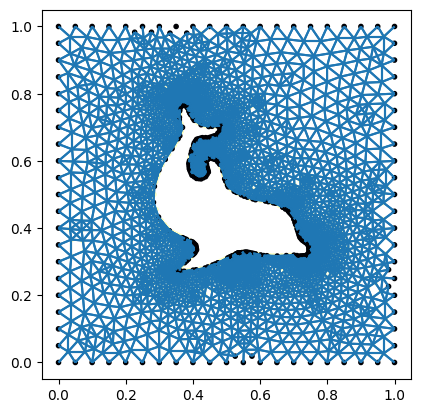

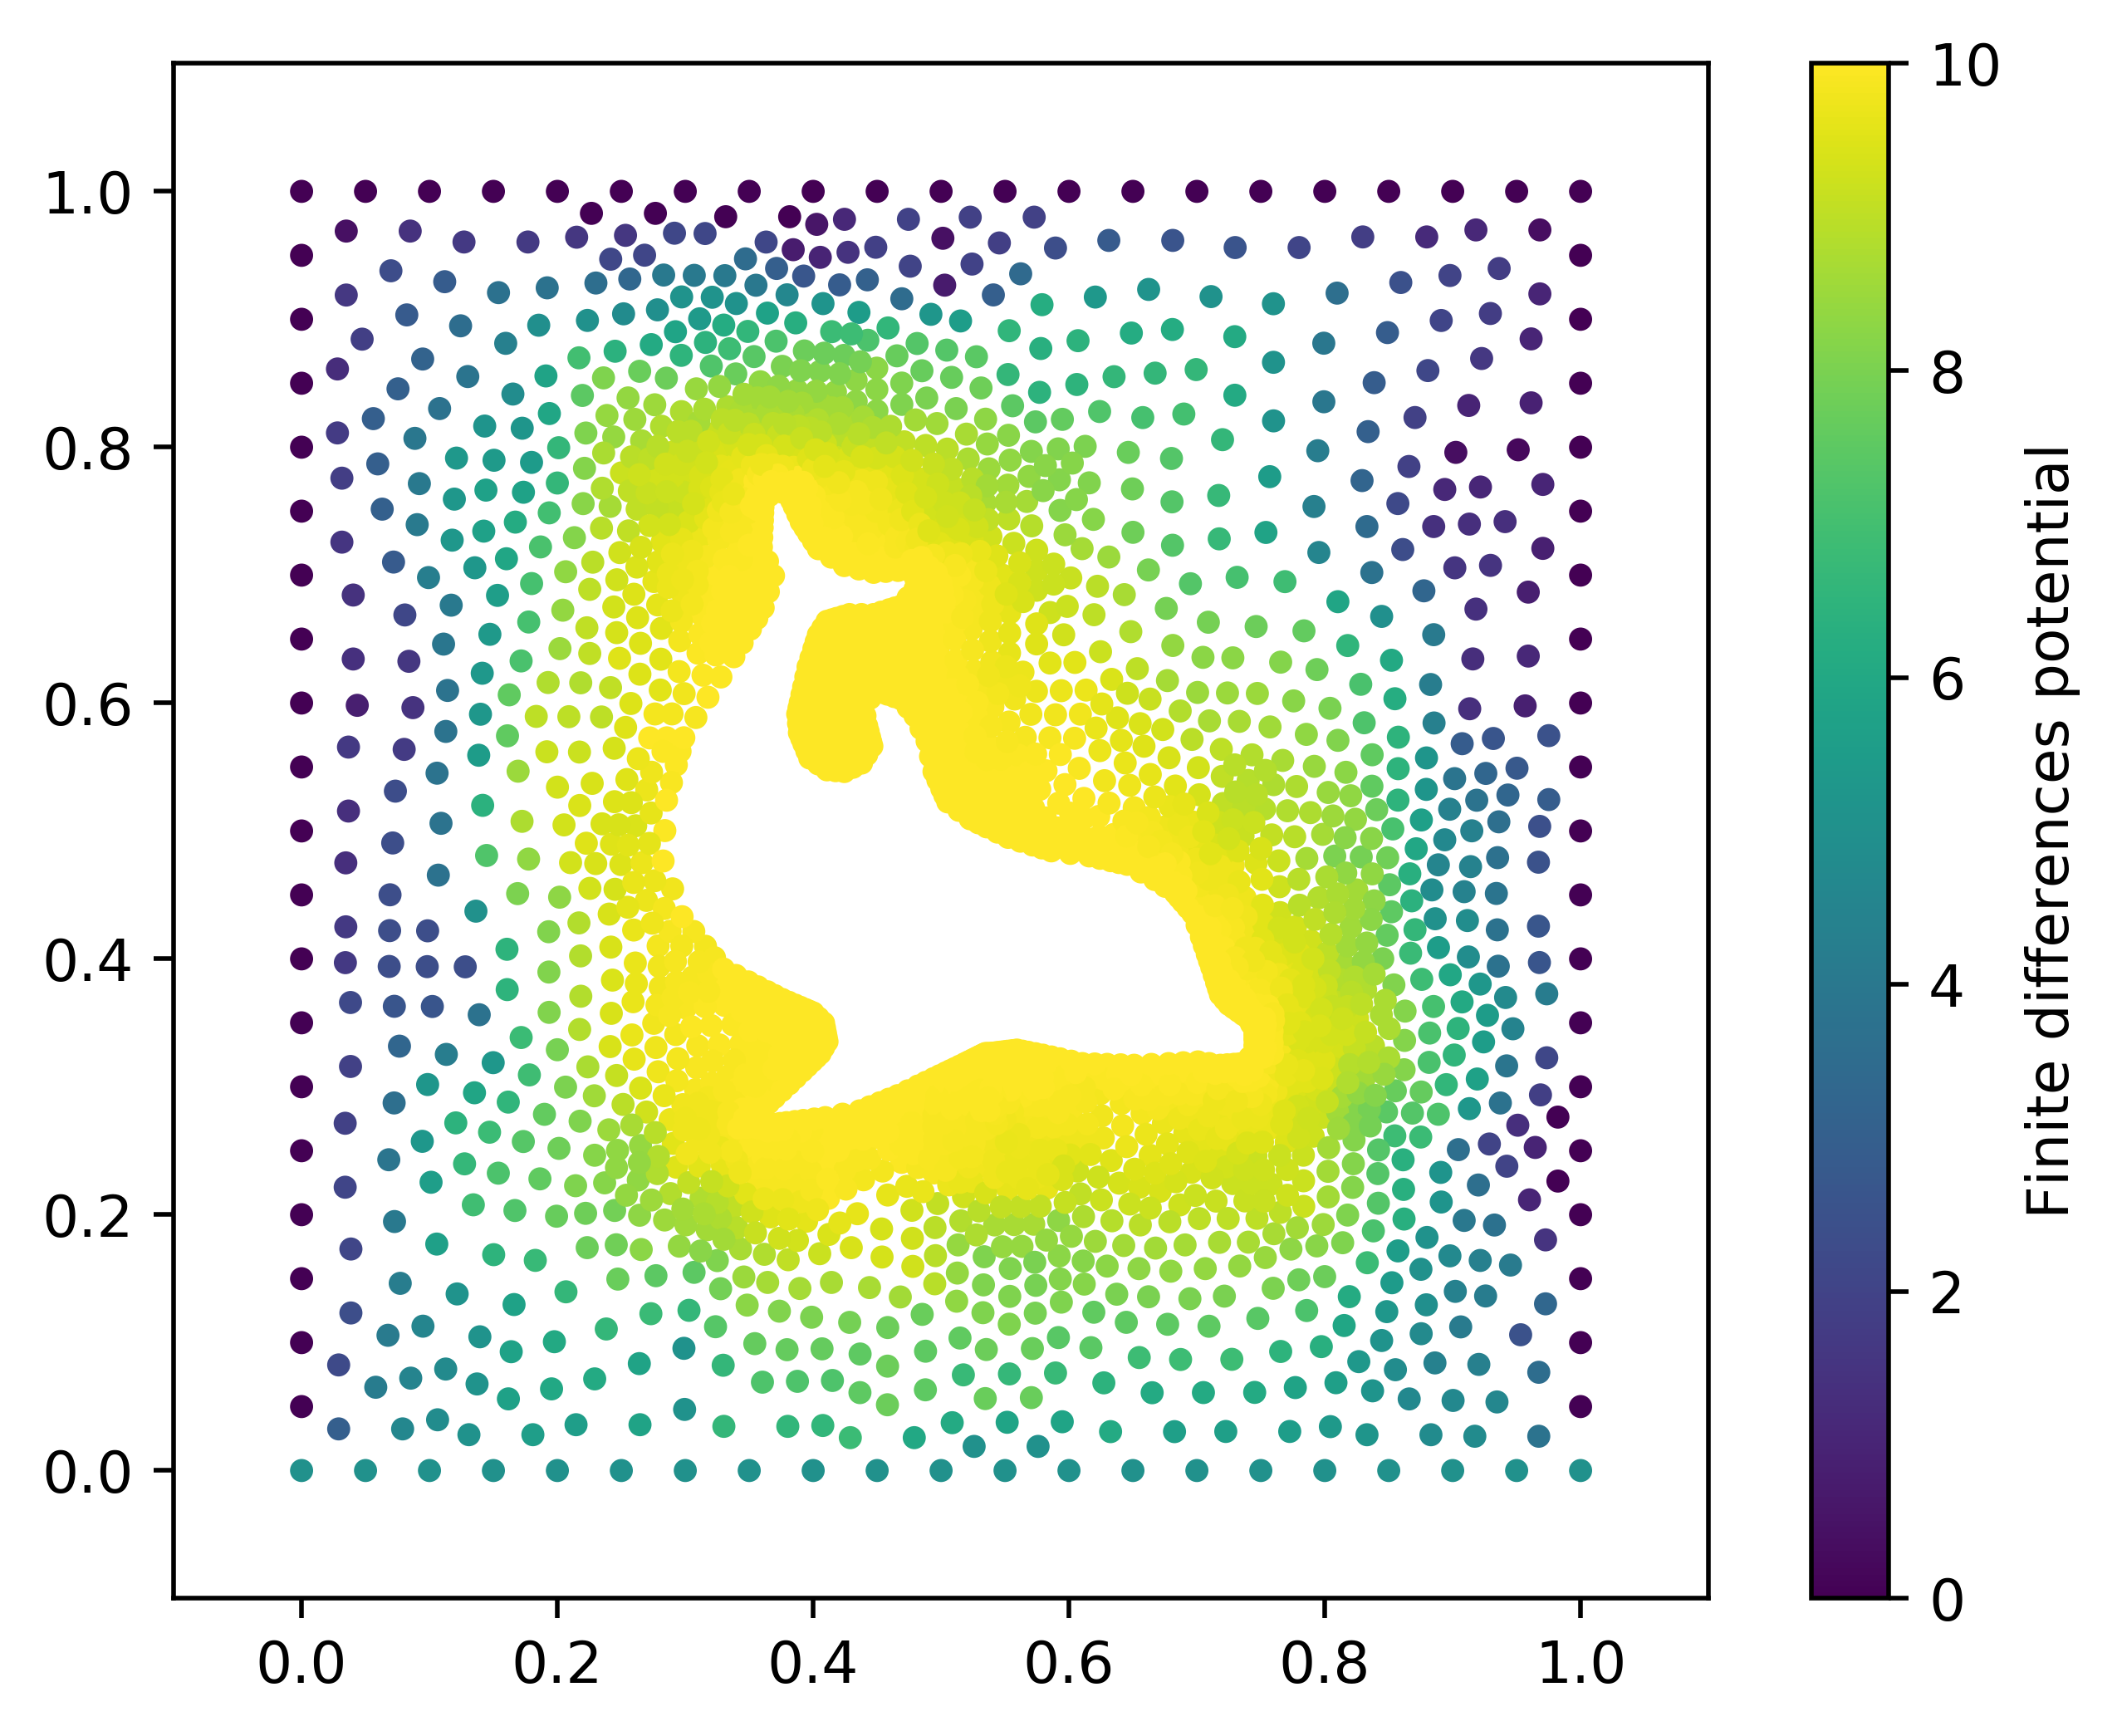

In [200]:
dolfin_solution.draw_connectivity()

fig, ax = plt.subplots(dpi=500)
plt.scatter([ pt.pos[0] for pt in dolfin_solution.all_points ],
            [ pt.pos[1] for pt in dolfin_solution.all_points ],
          c=[ pt.pot    for pt in dolfin_solution.all_points ],
     marker='.')
ax.set_aspect("equal")
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
cbar = plt.colorbar()
cbar.set_label('Finite differences potential')
plt.show()

In [162]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2023-12-10 22:31:25--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.109.153, 185.199.111.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-12-10 22:31:25 (29.6 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/2a03579/releases/pybind11-install.s

In [163]:
## Poisson Equation
# Load  FEM Packages
from fenics import *
from mshr import *
# Plotting Libraries
import matplotlib.pyplot as plt
plt.style.use("_classic_test_patch")

In [164]:
# Sub domain for no-slip (mark whole boundary, inflow and outflow will overwrite)
class Interior(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary

# Sub domain for inflow (right)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return x[0] > 1.0 - DOLFIN_EPS and on_boundary

# Sub domain for outflow (left)
class Right(SubDomain):
    def inside(self, x, on_boundary):
        return x[0] < DOLFIN_EPS and on_boundary

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return x[1] < DOLFIN_EPS and on_boundary

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return x[1] > 1.0 - DOLFIN_EPS and on_boundary

# Plotting Function
def PlotFields(u_field, e_field):
    """
    PlotFields(u_field, e_field)
    """
    fig = plt.figure(figsize = (14,10))                       # Set the resolution
    plt.subplot(121)
    figU = plot(u_field)
    plt.colorbar(figU, shrink=0.5)
    plt.title("Potential Field")
    plt.subplot(122)
    figE = plot(e_field)
    plt.colorbar(figE, shrink = 0.5)
    plt.title("Electric Field")
    plt.show()

In [165]:
mesh = Mesh('dolfin_fine.xml.gz')

In [166]:
# Create mesh functions over the cell facets
sub_domains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
# Mark all facets as sub domain 5
sub_domains.set_all(5)

interior = Interior()
left     = Left()
right    = Right()
bottom   = Bottom()
top      = Top()

interior.mark(sub_domains, 0)
left.mark(sub_domains, 1)
right.mark(sub_domains, 2)
bottom.mark(sub_domains, 3)
top.mark(sub_domains, 4)

In [201]:
V = FunctionSpace(mesh, 'P', 1)
# Boundary Conditions
bc0 = DirichletBC(V, Constant(10.0), sub_domains, 0)
bc1 = DirichletBC(V, Constant(0.0), sub_domains, 1)
bc2 = DirichletBC(V, Constant(0.0), sub_domains, 2)
bc3 = DirichletBC(V, Constant(5.0), sub_domains, 3)
bc4 = DirichletBC(V, Constant(0.0), sub_domains, 4)
bcs = [bc0, bc1, bc2, bc3, bc4]

In [202]:
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v)) * dx
L = Constant('0') * v * dx
u = Function(V)
solve(a == L, u, bcs)

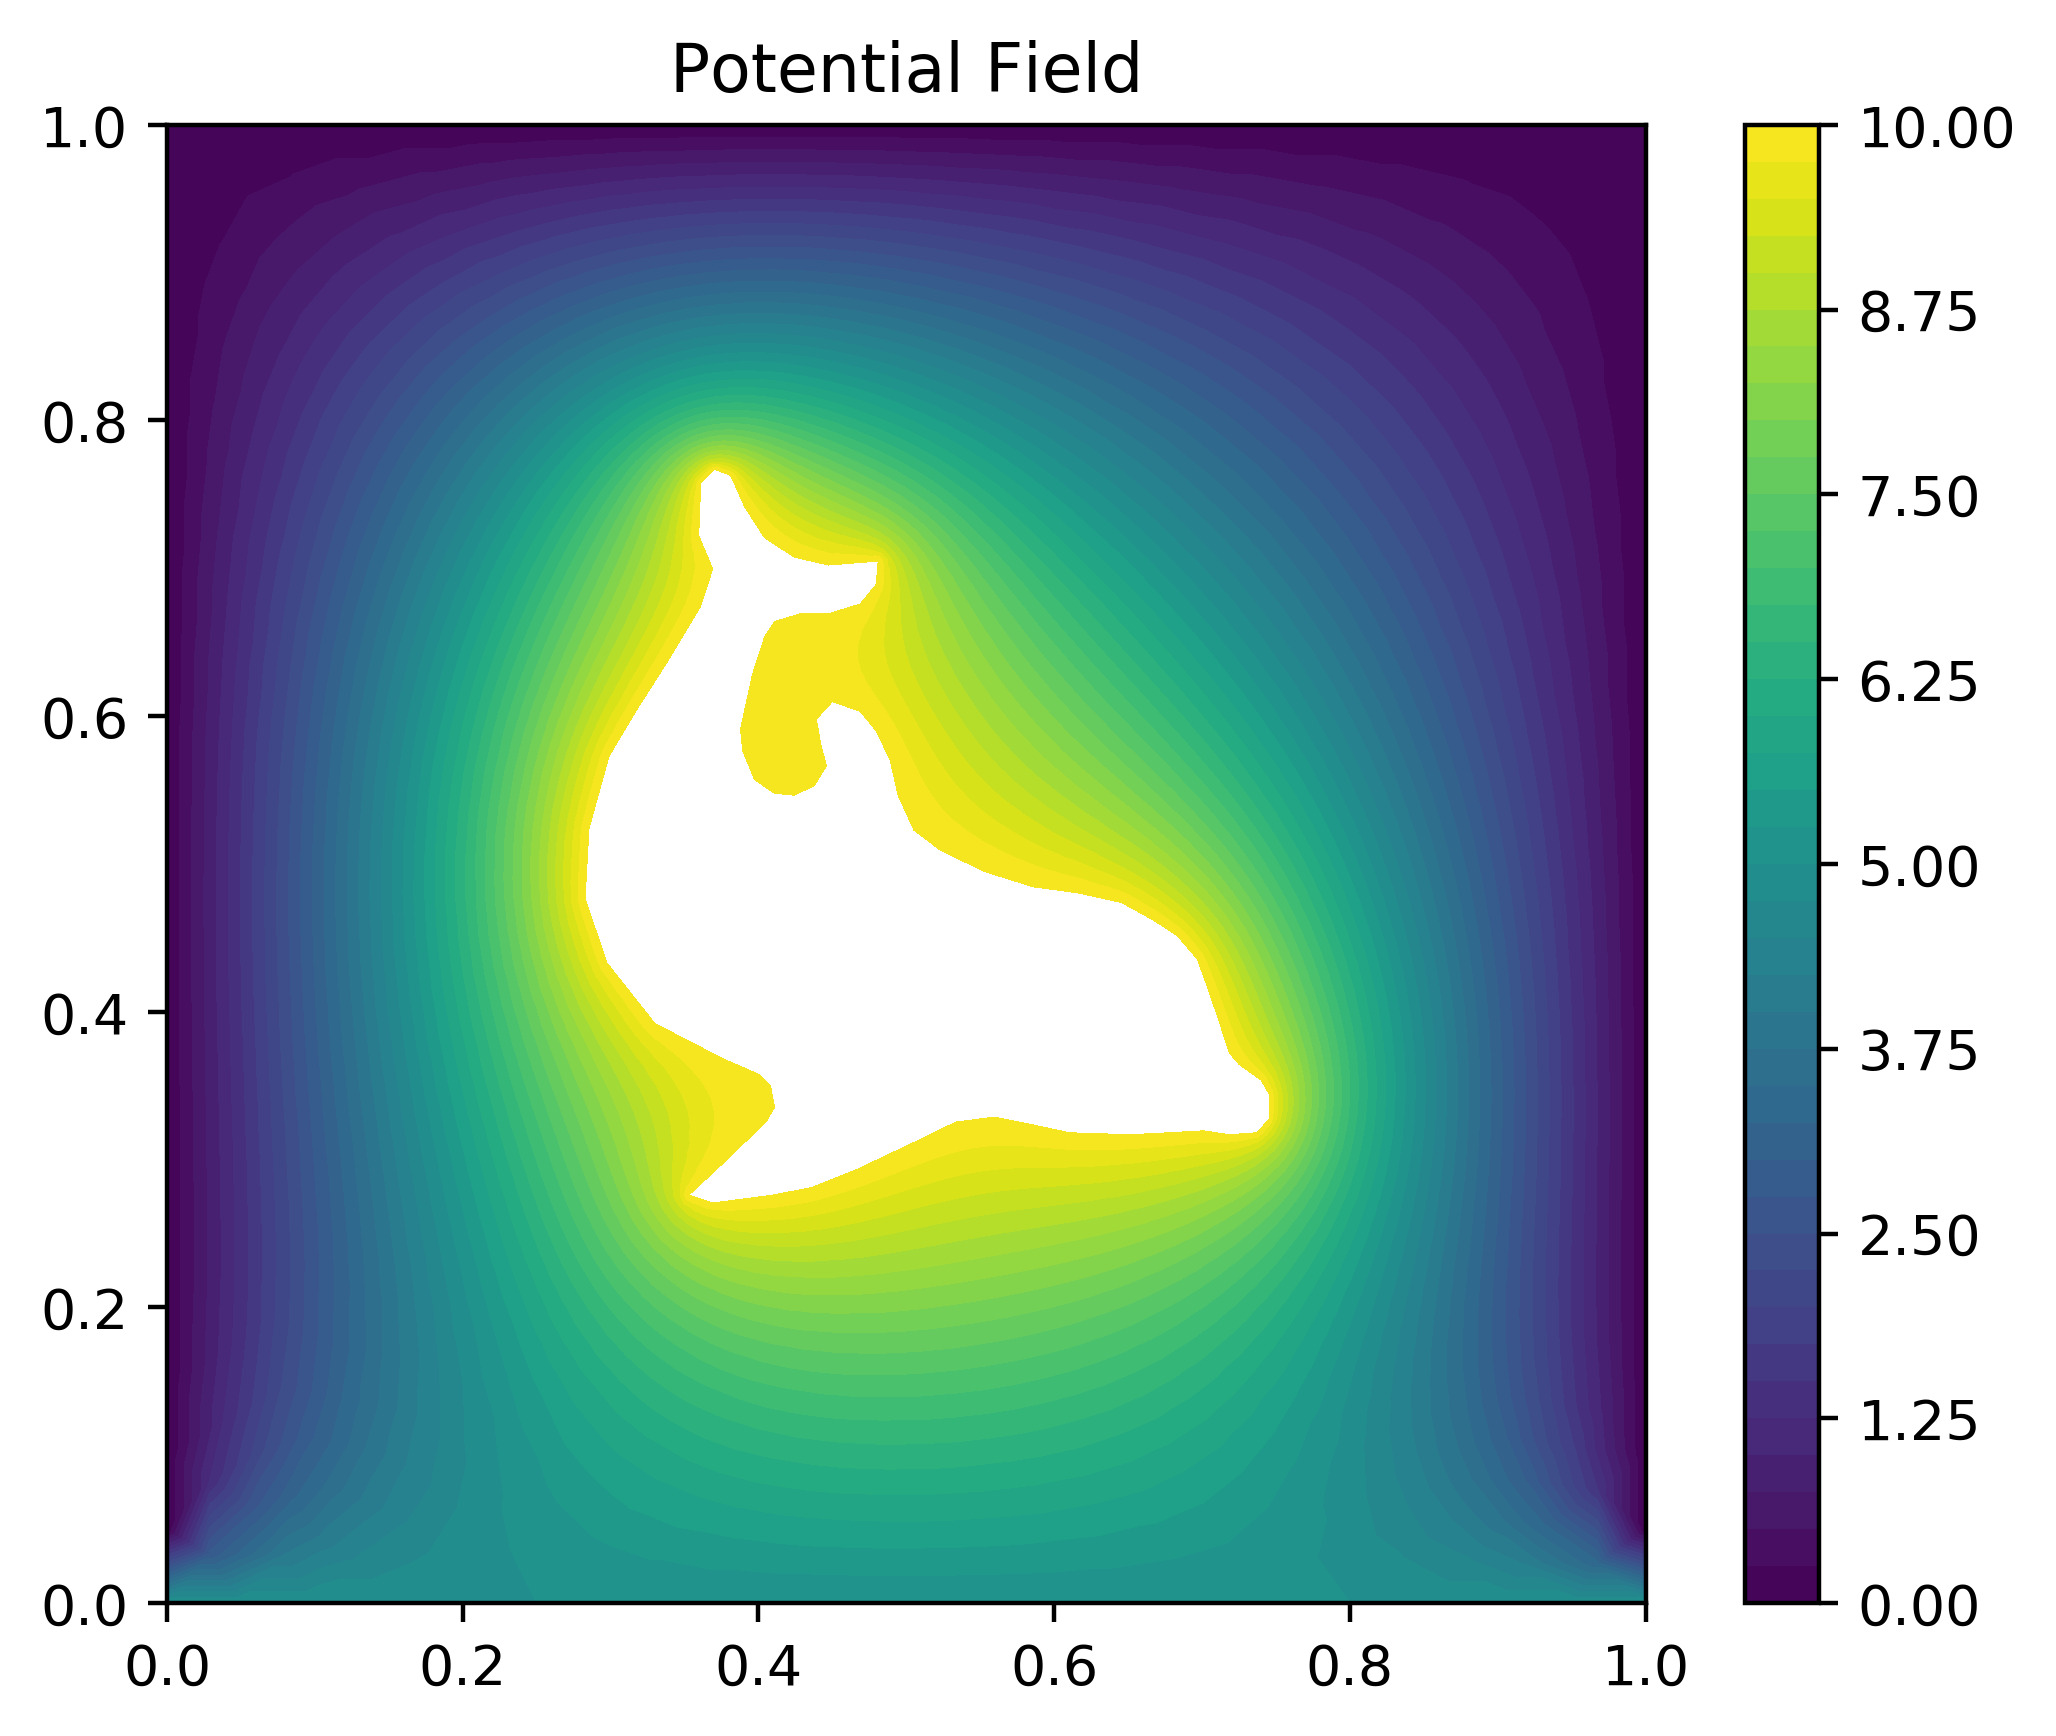

In [203]:
## Plotting the solution.
plt.figure(dpi=400)                       # Set the resolution
plot(u, title = 'Potential Field')              # Set the title
plt.colorbar(plot(u)) # Add a colorbar
plt.show()

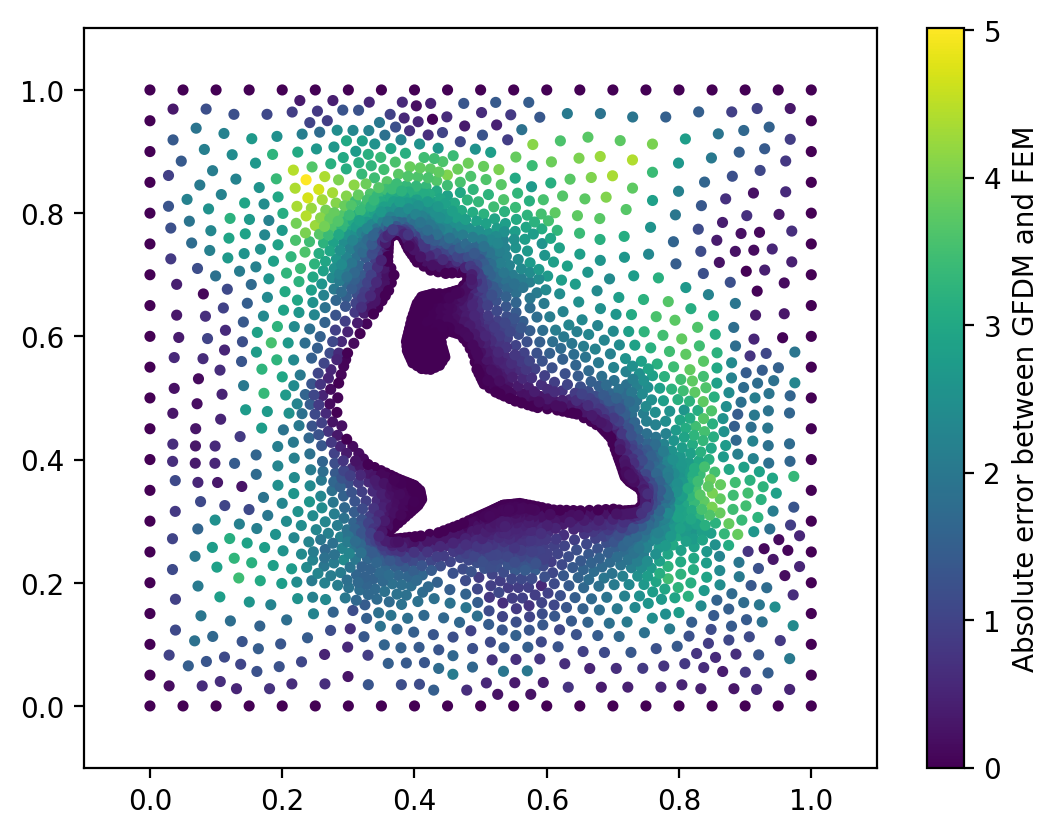

Root mean square error: 1.7065160444957792


In [209]:
# Take the FEM as the analytical solution...
def dolfin_fem_pot(point:MeshPoint) -> float:
  return u(Point(point.pos[0],point.pos[1]))

# Plot a scatter of the error between the analytic solution and the numerical solution.
def get_dolfin_error(point:MeshPoint) -> float:
  # Return value error between the numerical and analytic solution (numerical - analytic).
  numerical = point.pot
  analytic = dolfin_fem_pot(point)
  return abs(numerical - analytic)

fig, ax = plt.subplots(dpi=200)
plt.scatter([ pt.pos[0]            for pt in dolfin_solution.all_points ],
            [ pt.pos[1]            for pt in dolfin_solution.all_points ],
          c=[ get_dolfin_error(pt) for pt in dolfin_solution.all_points ],
     marker='.')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
cbar = plt.colorbar()
cbar.set_label('Absolute error between GFDM and FEM')
plt.show()

print(f'Root mean square error: {dolfin_solution.get_rms_error(dolfin_fem_pot)}')